In [18]:
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

import os
import time
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
data = pd.read_csv('train.csv')
data

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [20]:
data.label.value_counts()

label
1    10413
0    10387
Name: count, dtype: int64

In [21]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    text = str(text)    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

data['clean'] = data['text'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

In [22]:
# # keep only processed and label columns
# data[['processed', 'label']].to_csv('./fake_news_processed.csv', index=False, header=True)

In [23]:
data=pd.read_csv("fake_news_processed.csv")
data


,processed,label
0,House Dem Aide We Didnt Even See Comeys Letter...,1
1,Ever get feeling life circle roundabout rather...,0
2,"Why Truth Might Get You Fired October , The te...",1
3,Videos Civilians Killed In Single US Airstrike...,1
4,Print An Iranian woman sentenced six year pris...,1
...,...,...
20795,Rapper T . I . unloaded black celebrity met Do...,0
20796,When Green Bay Packers lost Washington Redskin...,0
20797,The Macys today grew union several great name ...,0
20798,"NATO , Russia To Hold Parallel Exercises In Ba...",1


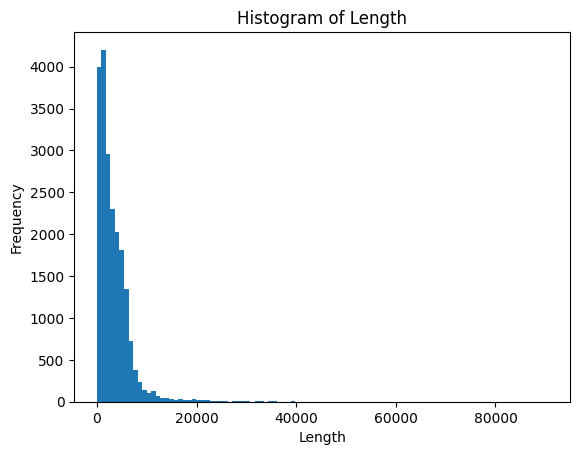

Min length: 1, Max length: 90520, Mean length: 3310.383846153846


In [24]:
import numpy as np
import numpy as np

#Some EDA
text = data.processed.values
text = [str(item) for item in text]
length = [len(item) for item in text]

plt.hist(length, bins=100)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Length')
plt.show()

length_min = np.min(length)
length_max = np.max(length)
length_mean = np.mean(length)

print(f'Min length: {length_min}, Max length: {length_max}, Mean length: {length_mean}')

In [25]:
#Building Vocab
text = data.processed.values
text = [str(item) for item in text]
words = ' '.join(text)
words = words.split()

counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
#Vocab size: 183415
word2int = {word: id for id, word in int2word.items()}

text_enc = [[word2int[word] for word in sentence.split()] for sentence in tqdm(text)]

100%|██████████| 20800/20800 [00:04<00:00, 4583.57it/s]


In [26]:
#Padding
def pad_features(text, pad_id, seq_length=128):
    features = np.full((len(text), seq_length), pad_id, dtype=int) # Filling all the values with pad_id
    for i, row in enumerate(text):
        features[i, :len(row)] = np.array(row)[:seq_length] # Filling the row with the values from the text and clipping off after seq_length
    return features

seq_length = 128
features = pad_features(text_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)
labels = data.label.to_numpy()


In [27]:
# train test split
train_size = .8     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

(16640, 128)

In [28]:

trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
batch_size = 64
train_dataloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(testset, shuffle=True, batch_size=batch_size)


In [29]:
hidden_size = 128
num_layers = 2
num_classes = 2
sequence_length = seq_length
embedding_dim = 128
vocab_size = len(word2int)

class NeuralNetwork(nn.Module):
    def __init__(self, embedding_dim,vocab_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True,dropout=0.5) #Don't have to specify sequence length becuase it can work on variable sequence length
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #(num_layers, batch_size, hidden_size)
        # Forward propagate RNN
        #Shape of x is (batch_size,sequence_length,input_size)
        out, _ = self.rnn(x, h0) #Shape of out is (batch_size,sequence_length,hidden_size) & _ is previous hidden state and shape is (num_layers,hidden_size)
        out = self.dropout(out)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

def train_loop(train_dataloader,val_dataloader,model,loss_fn,optimizer,batch_size,epoch):
    train_start_time = time.time()

    train_size=len(train_dataloader.dataset)
    num_batches=len(train_dataloader)
    loss_tot=0
    train_correct=0

    for batch,(X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()
        pred=model(X)
        loss=loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot+=loss.item()
        
        model.eval()
        pred=model(X)
        train_correct_each = (pred.argmax(1) == y).type(torch.float).sum().item()
        train_acc=train_correct_each/(y.shape[0])
        train_correct+=train_correct_each
        loss, current = loss.item(), batch * batch_size + len(X)

        train_end_time = time.time() 
        train_duration = train_end_time - train_start_time 

        print(f"\rEpoch {epoch+1} : Training loss: {loss:>7f} - Training Accuracy: {train_acc:>7f}  [{current:>5d}/{train_size:>5d}] - Training Time: {train_duration:.2f}s", end="")

    loss_avg=loss_tot/num_batches
    train_acc = train_correct/train_size

    val_loss = 0
    val_correct=0
    val_size=len(val_dataloader.dataset)

    model.eval()
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= len(val_dataloader)
    val_acc=val_correct/val_size

    print(f"\rEpoch {epoch+1} : Training loss: {loss_avg:>7f} - Training Accuracy: {train_acc:>7f} - Validation loss: {val_loss:>7f} - Validation accuracy: {val_acc:>7f} - Training Time: {train_duration:.2f}s")
    print(end='')
    return loss_avg, train_acc, val_loss, val_acc


def test_loop(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    model.eval()
    num_batches=len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc=correct/size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

model=NeuralNetwork(embedding_dim,vocab_size, hidden_size, num_layers, num_classes).to(device)
learning_rate = 1e-3
batch_size = batch_size
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

sample_input_for_summary = torch.randint(0, vocab_size, (batch_size, sequence_length)).to(device)

summary(model, input_data=sample_input_for_summary)

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [64, 2]                   --
├─Embedding: 1-1                         [64, 128, 128]            23,477,120
├─RNN: 1-2                               [64, 128, 128]            66,048
├─Dropout: 1-3                           [64, 128, 128]            --
├─Linear: 1-4                            [64, 2]                   32,770
Total params: 23,575,938
Trainable params: 23,575,938
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.05
Input size (MB): 0.07
Forward/backward pass size (MB): 16.78
Params size (MB): 94.30
Estimated Total Size (MB): 111.15

In [30]:
loss_history = {'train': [], 'val': []}
accuracy_history = {'train': [], 'val': []}

best_val_loss = float('inf')
patience = 10  # How many epochs to wait after last improvement
patience_counter = 0 
min_delta=0.001

for t in range(epochs):
    print(f"Epoch {t+1}",end=" ")
    train_loss, train_accuracy, val_loss, val_accuracy =train_loop(train_dataloader,validation_dataloader, model, loss_fn, optimizer,batch_size,t)
    # test_loop(test_dataloader, model, loss_fn)
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    accuracy_history['train'].append(train_accuracy)
    accuracy_history['val'].append(val_accuracy)

    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        patience_counter += 1 
    
    if patience_counter >= patience:
        print(f"\nStopping early at epoch {t+1} with restoring best weights")
        epochs=t+1
        break 
    

Epoch 1 : Training loss: 0.625807 - Training Accuracy: 0.654748 - Validation loss: 0.497664 - Validation accuracy: 0.775000 - Training Time: 25.94s
Epoch 2 : Training loss: 0.389991 - Training Accuracy: 0.842067 - Validation loss: 0.319230 - Validation accuracy: 0.859135 - Training Time: 25.71s
Epoch 3 : Training loss: 0.245755 - Training Accuracy: 0.915204 - Validation loss: 0.256649 - Validation accuracy: 0.900000 - Training Time: 25.68s
Epoch 4 : Training loss: 0.167971 - Training Accuracy: 0.958474 - Validation loss: 0.235013 - Validation accuracy: 0.919712 - Training Time: 25.69s
Epoch 5 : Training loss: 0.117955 - Training Accuracy: 0.980829 - Validation loss: 0.275375 - Validation accuracy: 0.931731 - Training Time: 25.76s
Epoch 6 : Training loss: 0.105949 - Training Accuracy: 0.988101 - Validation loss: 0.369164 - Validation accuracy: 0.937500 - Training Time: 25.68s
Epoch 7 : Training loss: 0.071465 - Training Accuracy: 0.993930 - Validation loss: 0.459935 - Validation accurac

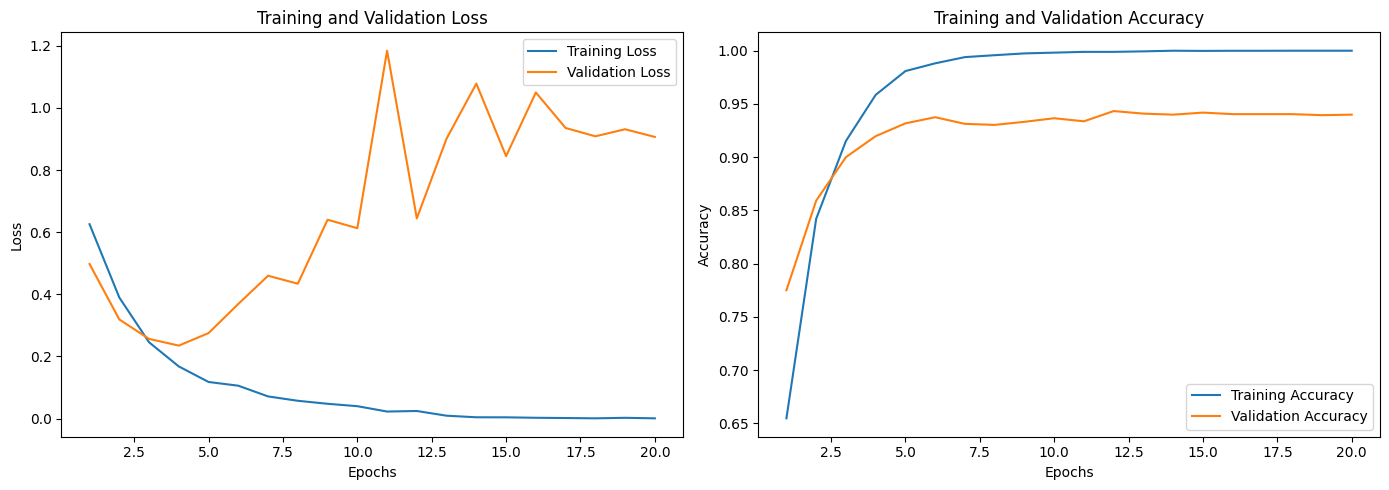

In [31]:
plt.figure(figsize=(14, 5))
eplist=[]
for i in range(epochs):
    eplist.append(i+1)
plt.subplot(1, 2, 1)
plt.plot(eplist, loss_history['train'], label='Training Loss')
plt.plot(eplist, loss_history['val'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eplist, accuracy_history['train'], label='Training Accuracy')
plt.plot(eplist, accuracy_history['val'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()